In [1]:
from pathlib import Path
import torch
import json
from dataclasses import dataclass
import debugviz 
import warnings

import llama

input = {
    'ckpt_dir'       : "weights/7B",
    'tokenizer_path' : "weights/tokenizer.model",
    'temperature'    : 0.8,
    'top_p'          : 0.95,
    'max_seq_len'    : 32,
    'max_batch_size' : 32,
}

warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

### Set up distributed work

In [2]:
import os
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = '10.128.15.205'
os.environ['MASTER_PORT'] = '12345'

from fairscale.nn.model_parallel.initialize import initialize_model_parallel
def setup_model_parallel():
    local_rank = int(os.environ.get("LOCAL_RANK", -1))
    world_size = int(os.environ.get("WORLD_SIZE", -1))

    torch.distributed.init_process_group("nccl")
    initialize_model_parallel(world_size)
    torch.cuda.set_device(local_rank)

    # seed must be the same in all processes
    torch.manual_seed(1)
    return local_rank, world_size

local_rank, world_size = setup_model_parallel()
print(f'{local_rank=} {world_size=}')

> initializing model parallel with size 1
> initializing ddp with size 1
> initializing pipeline with size 1
local_rank=-1 world_size=1


### Model Args and Params

In [3]:
checkpoints = sorted(Path(input['ckpt_dir']).glob("*.pth"))
print(f'{len(checkpoints)=} {world_size=}')

ckpt_path = checkpoints[local_rank]
checkpoint = torch.load(ckpt_path, map_location="cpu")
with open(Path(input['ckpt_dir']) / "params.json", "r") as f:
        params = json.loads(f.read())

@dataclass
class ModelArgs:
    dim: int = 512
    n_layers: int = 8
    n_heads: int = 8
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    norm_eps: float = 1e-5
    
    vocab_size: int = -1  # defined later by tokenizer
    max_batch_size: int = 32
    max_seq_len: int = 2048

model_args = ModelArgs(
        max_seq_len=input['max_seq_len'],
        max_batch_size=input['max_batch_size'],
        **params)

tokenizer = llama.Tokenizer(model_path=input['tokenizer_path'])
model_args.vocab_size = tokenizer.n_words

torch.set_default_tensor_type(torch.cuda.HalfTensor)
model = llama.Transformer(model_args)
torch.set_default_tensor_type(torch.FloatTensor)

model.load_state_dict(checkpoint, strict=False)

generator = llama.LLaMA(model, tokenizer)

prompts = ["I believe the meaning of life is",]
generator.generate(prompts, max_gen_len=256, temperature=input['temperature'], top_p=input['top_p'],)

len(checkpoints)=1 world_size=1


['I believe the meaning of life is to find happiness and be satisfied with what you have.\nPeople have different definitions of happiness. Some people feel that']

# Break-down : Generate

### Break-down : llama.Tokenizer

In [4]:
text = "I believe the meaning of life is"
BATCH = 1 # batch size
print(f'{text=}')

from sentencepiece import SentencePieceProcessor
sp_model = SentencePieceProcessor(model_file=input['tokenizer_path'])

n_words: int = sp_model.vocab_size()
bos_id:  int = sp_model.bos_id()
eos_id:  int = sp_model.eos_id()
pad_id:  int = sp_model.pad_id()

text = sp_model.encode(text)
print(f'\nEncode:\n{text=}')

text = [bos_id] + text
print(f'+bos:\n{text=}')

tokens = torch.full((BATCH, model_args.max_seq_len), pad_id).cuda().long()
print(f'\nPrepare output tensor:\n{tokens=}\n{tokens.shape=}')

tokens[BATCH-1, : len(text)] = torch.tensor(text).long()
print(f'\n{tokens.shape=}\n{tokens=}')

print(f'\nPrepare mask for next token generation:')
input_text_mask = tokens != pad_id
print(f'{input_text_mask=}')

start_pos = len(text)
prev_pos = 0
print(f'\n{start_pos=} {prev_pos=}')

whole_tokens = tokens
print(f'{whole_tokens.shape=}')

cur_pos = start_pos

print('✅Done. Input text (whole_tokens) is pre-processed and ready to go')

text='I believe the meaning of life is'

Encode:
text=[306, 4658, 278, 6593, 310, 2834, 338]
+bos:
text=[1, 306, 4658, 278, 6593, 310, 2834, 338]

Prepare output tensor:
tokens=tensor([[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       device='cuda:0')
tokens.shape=torch.Size([1, 32])

tokens.shape=torch.Size([1, 32])
tokens=tensor([[   1,  306, 4658,  278, 6593,  310, 2834,  338,   -1,   -1,   -1,   -1,
           -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1,
           -1,   -1,   -1,   -1,   -1,   -1,   -1,   -1]], device='cuda:0')

Prepare mask for next token generation:
input_text_mask=tensor([[ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False]], device='cuda:0')

st

### Break-down : llama.model.Transformer.forward

Full-length output tensor:
whole_tokens.shape=torch.Size([1, 32])

Current tokens:
tokens=tensor([[   1,  306, 4658,  278, 6593,  310, 2834,  338]], device='cuda:0')
tokens.shape=torch.Size([1, 8])

Embeddings:
[[0.123, 3.21, -1.23 ...], [1.23, -3.21, ...], ... ]
emb.shape=torch.Size([1, 8, 4096])

Init rotary embedding freqs:
freqs 1/(theta ^(i/dim)):
decay: [1.0, 0.86, 0.75, 0.64, 0.56 , ..., 0.0002, 0.0002, 0.0002, 0.0002, 0.0001 ] shape=[64]
t: [0, 1, 2, 3, 4, .... , 62, 63] shape=[64]
freqs = decay × t : freqs.shape=torch.Size([64, 64])

Populate polar coordinates (dtype=complex) Freqs_cis.shape=torch.Size([64, 64])

Complex exponential values on the unit circle: 


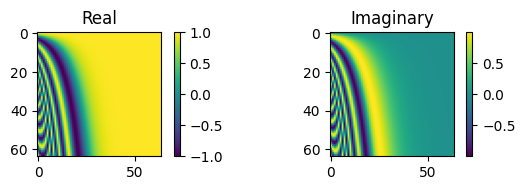

Current complex exp vals: 


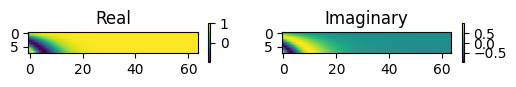

✅Done. Embeddings emb.shape=torch.Size([1, 8, 4096]) are computed and ready to go


In [5]:
start_pos = prev_pos # 0

print(f'Full-length output tensor:\n{whole_tokens.shape=}')
tokens = whole_tokens[:, prev_pos:cur_pos]
print(f'\nCurrent tokens:\n{tokens=}\n{tokens.shape=}')

_, seqlen = tokens.shape

embedding_matrix = model.tok_embeddings.weight
embeddings = torch.nn.Embedding.from_pretrained(embedding_matrix)

emb = embeddings(tokens) # same as model.tok_embeddings(tokens)
print(f'\nEmbeddings:\n[[0.123, 3.21, -1.23 ...], [1.23, -3.21, ...], ... ]\n{emb.shape=}\n')

print('Init rotary embedding freqs:')
if True: # down-brake : precompute_freqcs_cis
    dim = model_args.dim // model_args.n_heads
    end = model_args.max_seq_len * 2
    theta = 10000.0

    print('freqs 1/(theta ^(i/dim)):\ndecay: [1.0, 0.86, 0.75, 0.64, 0.56 , ..., 0.0002, 0.0002, 0.0002, 0.0002, 0.0001 ] shape=[64]')
    decay = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))

    print('t: [0, 1, 2, 3, 4, .... , 62, 63] shape=[64]')
    t = torch.arange(end, device=decay.device)

    # pair product of vectors t & freqs => matrix
    freqs = torch.outer(t, decay).float()
    print(f'freqs = decay × t : {freqs.shape=}')

    # Cartesian coordinates corresponding to the polar coordinates with val = 1, angle = freqs)
    Freqs_cis = torch.polar(torch.ones_like(freqs), freqs) # dtype = complex64
    print(f'\nPopulate polar coordinates (dtype=complex) {Freqs_cis.shape=}')

    Freqs_cis = Freqs_cis.to(emb.device)
    print("\nComplex exponential values on the unit circle: ")
    debugviz.colorbar(Freqs_cis)

freqs_cis = Freqs_cis[start_pos : start_pos + seqlen]
print("Current complex exp vals: ")
debugviz.colorbar(freqs_cis, adjust=0.5)

mask = None # Upper-triangular mask matrix
if seqlen > 1: # more than 1 input token
    mask = torch.full((1, 1, seqlen, seqlen), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=start_pos + 1).type_as(emb)

print(f'✅Done. Embeddings {emb.shape=} are computed and ready to go')

# Break-Down llama.model.TransformerBlock

### RMSNorm pre-attention

In [6]:
# Residual Connection
residual_emb = emb.clone()

# Pre-normalization RMSNorm 1/sqrt(E[emb**2] + eps)
attn_norm = emb.float() * torch.rsqrt(emb.float().pow(2).mean(-1, keepdim=True) + model_args.norm_eps)
attn_norm_weight = torch.nn.Parameter(torch.ones(model_args.dim))
attn_norm_weight.data = model.layers[0].attention_norm.weight.data
pre_attn_norm = attn_norm.type_as(emb) * attn_norm_weight
print(f'Pre-attention normalization : {pre_attn_norm.shape=}')

assert (pre_attn_norm == model.layers[0].attention_norm(emb)).all(), "Attn RMSNorm not like REF"
print("Attn RMSNorm RECONCILED!")


Pre-attention normalization : pre_attn_norm.shape=torch.Size([1, 8, 4096])
Attn RMSNorm RECONCILED!


### Attention

In [7]:
print('1 = batch \t 8 = nb. Input Words \t 4096 = emb size \t 32 = nb. heads \t 128 head dim\n')
if True: # Attention.__init__:
    head_dim = model_args.dim // model_args.n_heads
    n_local_heads = model_args.n_heads // world_size
    assert n_local_heads == model.layers[0].attention.n_local_heads, 'Not like REF'

    assert (model_args.n_heads * head_dim, model_args.dim) == model.layers[0].attention.wq.weight.shape
    wq = torch.nn.Linear(model_args.dim, model_args.n_heads * head_dim, bias=False) # ref no bias
    wq.weight.data = model.layers[0].attention.wq.weight.data

    assert (model_args.n_heads * head_dim, model_args.dim) == model.layers[0].attention.wk.weight.shape
    wk = torch.nn.Linear(model_args.dim, model_args.n_heads * head_dim, bias=False) # ref no bias
    wk.weight.data = model.layers[0].attention.wk.weight.data

    assert (model_args.n_heads * head_dim, model_args.dim) == model.layers[0].attention.wv.weight.shape
    wv = torch.nn.Linear(model_args.dim, model_args.n_heads * head_dim, bias=False) # ref no bias
    wv.weight.data = model.layers[0].attention.wv.weight.data

    assert (model_args.n_heads * head_dim, model_args.dim) == model.layers[0].attention.wo.weight.shape
    wo = torch.nn.Linear(model_args.dim, model_args.n_heads * head_dim, bias=False) # ref no bias
    wo.weight.data = model.layers[0].attention.wo.weight.data

# attention.forward(h, start_pos, freqs_cis, mask)

print(f'Query-Key-Value:')
query = wq(pre_attn_norm)
key = wk(pre_attn_norm)
value = wv(pre_attn_norm)
print(f'\t{query.shape=}\n\t{key.shape=}\n\t{value.shape=}')

print(f'Split to {pre_attn_norm.shape=} to {n_local_heads} heads')
query=query.view(BATCH, seqlen, n_local_heads, head_dim)
key=key.view(BATCH, seqlen, n_local_heads, head_dim)
value=value.view(BATCH, seqlen, n_local_heads, head_dim)
print(f'\t{query.shape=}\n\t{key.shape=}\n\t{value.shape=}')

print('START ADD Rotary Embeddings.\n\tGo to complex:')
xq_complex = torch.view_as_complex(query.float().reshape(*query.shape[:-1], -1, 2))
xk_conplex = torch.view_as_complex(key.float().reshape(*key.shape[:-1], -1, 2))
print(f'\t{xq_complex.shape=}\n\t{xk_conplex.shape=}')

shape = [d if i == 1 or i == xq_complex.ndim - 1 else 1 for i, d in enumerate(xk_conplex.shape)]
broadcasted_reqs_cis = freqs_cis.view(*shape)
print(f'\t{shape=}')

print('\tBack to Real:')
xq_real = torch.view_as_real(xq_complex * broadcasted_reqs_cis).flatten(3).type_as(query)
xk_real = torch.view_as_real(xk_conplex * broadcasted_reqs_cis).flatten(3).type_as(key)
print(f'\t{xq_real.shape=}\n\t{xk_real.shape=}')
print(f'END Rotary Embeddings.\n')

1 = batch 	 8 = nb. Input Words 	 4096 = emb size 	 32 = nb. heads 	 128 head dim

Query-Key-Value:
	query.shape=torch.Size([1, 8, 4096])
	key.shape=torch.Size([1, 8, 4096])
	value.shape=torch.Size([1, 8, 4096])
Split to pre_attn_norm.shape=torch.Size([1, 8, 4096]) to 32 heads
	query.shape=torch.Size([1, 8, 32, 128])
	key.shape=torch.Size([1, 8, 32, 128])
	value.shape=torch.Size([1, 8, 32, 128])
START ADD Rotary Embeddings.
	Go to complex:
	xq_complex.shape=torch.Size([1, 8, 32, 64])
	xk_conplex.shape=torch.Size([1, 8, 32, 64])
	shape=[1, 8, 1, 64]
	Back to Real:
	xq_real.shape=torch.Size([1, 8, 32, 128])
	xk_real.shape=torch.Size([1, 8, 32, 128])
END Rotary Embeddings.



In [8]:
print(f'\t{xq_real.shape=}\n\t{xk_real.shape=}\n\t{value.shape=}')

print('Transpose Q-K-V N_WORDS <-> N_HEADS')
query = xq_real.transpose(1, 2)
key = xk_real.transpose(1, 2)
value = value.transpose(1, 2)
print(f'\t{query.shape=}\n\t{key.shape=}\n\t{value.shape=}')

key_t = key.transpose(2, 3)
print(f'\t{key_t.shape=}')

print('Scores -> Probability Distrib over attention')
scores = torch.matmul(query, key_t) / (head_dim ** 0.5)
print(f'\t{scores.shape=}')

if mask is not None:
    scores = scores + mask

p_attn = torch.nn.functional.softmax(scores.float(), dim=-1).type_as(query)
print(f'\t{p_attn.shape=}')

head_context = torch.matmul(p_attn, value)
print(f'{head_context.shape=}')

print('Transpose back N_HEADS <-> N_WORDS')
context = head_context.transpose(1, 2).contiguous()
print(f'\t{context.shape=}')

print("Collapse head context by heads:")
context = context.view(BATCH, seqlen, -1)
print(f'\t{context.shape=}')

print('Final output linear layer:')
attn_output = wo(context)
print(f'\t{attn_output.shape=}')

assert (attn_output == model.layers[0].attention(pre_attn_norm, start_pos, freqs_cis, mask)).all(), "Attention not like REF"
print("Attention RECONCILED!")

context = attn_output + residual_emb

	xq_real.shape=torch.Size([1, 8, 32, 128])
	xk_real.shape=torch.Size([1, 8, 32, 128])
	value.shape=torch.Size([1, 8, 32, 128])
Transpose Q-K-V N_WORDS <-> N_HEADS
	query.shape=torch.Size([1, 32, 8, 128])
	key.shape=torch.Size([1, 32, 8, 128])
	value.shape=torch.Size([1, 32, 8, 128])
	key_t.shape=torch.Size([1, 32, 128, 8])
Scores -> Probability Distrib over attention
	scores.shape=torch.Size([1, 32, 8, 8])
	p_attn.shape=torch.Size([1, 32, 8, 8])
head_context.shape=torch.Size([1, 32, 8, 128])
Transpose back N_HEADS <-> N_WORDS
	context.shape=torch.Size([1, 8, 32, 128])
Collapse head context by heads:
	context.shape=torch.Size([1, 8, 4096])
Final output linear layer:
	attn_output.shape=torch.Size([1, 8, 4096])
Attention RECONCILED!


### RMSNorm pre-feed-forward

In [9]:
# Residual Connection
residual_context = context.clone()

print(f'{context.shape=}')
# Pre-normalization RMSNorm
ffn_norm = context.float() * torch.rsqrt(context.float().pow(2).mean(-1, keepdim=True) + model_args.norm_eps)
ffn_norm_weight = torch.nn.Parameter(torch.ones(model_args.dim))
ffn_norm_weight.data = model.layers[0].ffn_norm.weight.data
pre_ffn_norm = ffn_norm.type_as(context) * ffn_norm_weight
print(f'{pre_ffn_norm.shape=}')

assert (pre_ffn_norm == model.layers[0].ffn_norm(context)).all(), "FFN RMSNorm not like REF"
print("FFN RMSNorm RECONCILED!")

context.shape=torch.Size([1, 8, 4096])
pre_ffn_norm.shape=torch.Size([1, 8, 4096])
FFN RMSNorm RECONCILED!


### Feed Forward

In [10]:
if True:# FeedForward.__init__:
    multiple_of = model_args.multiple_of

    hidden_dim = 4 * model_args.dim
    hidden_dim = int(2 * hidden_dim / 3)
    hidden_dim = multiple_of * ((hidden_dim + multiple_of - 1) // multiple_of)

    assert (hidden_dim, model_args.dim) == model.layers[0].feed_forward.w1.weight.shape
    w1 = torch.nn.Linear(model_args.dim, hidden_dim, bias=False) # ref no bias
    w1.weight.data = model.layers[0].feed_forward.w1.weight.data

    assert (model_args.dim, hidden_dim) == model.layers[0].feed_forward.w2.weight.shape
    w2 = torch.nn.Linear(hidden_dim, model_args.dim, bias=False) # ref no bias
    w2.weight.data = model.layers[0].feed_forward.w2.weight.data

    assert (hidden_dim, model_args.dim) == model.layers[0].feed_forward.w3.weight.shape
    w3 = torch.nn.Linear(model_args.dim, hidden_dim, bias=False) # ref no bias
    w3.weight.data = model.layers[0].feed_forward.w3.weight.data

# FeedForward.forward

print(f'{pre_ffn_norm.shape=}')
print('Feed Forward 1 SiLU(Linear(pre_ffn_norm)):')
z1 = w1(pre_ffn_norm)
a1 = torch.nn.functional.silu(z1)
print(f'\t{a1.shape=}')

print('Feed Forward 2 (a1 * Linear(pre_ffn_norm)):')
z2 = a1 * w3(pre_ffn_norm)
print(f'\t{z2.shape=}')

print('Feed Forward 3 Linear(z2):')
ffn_output = w2(z2)
print(f'\t{ffn_output.shape=}')

assert (ffn_output == model.layers[0].feed_forward.forward(pre_ffn_norm)).all(), "FFN not like REF"
print("Feed Forward RECONCILED!")

context = ffn_output + residual_context


print(f'')

print(f'✅Done. {context.shape=} is UPDATED. REPEAT same update 32 times ')

pre_ffn_norm.shape=torch.Size([1, 8, 4096])
Feed Forward 1 SiLU(Linear(pre_ffn_norm)):
	a1.shape=torch.Size([1, 8, 11008])
Feed Forward 2 (a1 * Linear(pre_ffn_norm)):
	z2.shape=torch.Size([1, 8, 11008])
Feed Forward 3 Linear(z2):
	ffn_output.shape=torch.Size([1, 8, 4096])
Feed Forward RECONCILED!

✅Done. context.shape=torch.Size([1, 8, 4096]) is UPDATED. REPEAT same update 32 times 


In [11]:
assert (context == model.layers[0].forward(emb, start_pos, freqs_cis, mask)).all(), "TransformerBlock not like REF"
print("TransformerBlock RECONCILED!")

# end of reconciliation tracking (no more need for meaningful values)
for _ in range(32):
    context = context
print(f'{context.shape=}')

print('Final normalisation:')
final_norm_weight = torch.nn.Parameter(torch.ones(model_args.dim))
final_norm_weight.data = model.norm.weight.data # optional

final_norm = context.float() * torch.rsqrt(context.float().pow(2).mean(-1, keepdim=True) + model_args.norm_eps)
pre_classification_context = final_norm.type_as(context) * final_norm_weight
print(f'\t{pre_classification_context.shape=}')

print('Classification:')
classification = torch.nn.Linear(model_args.dim, model_args.vocab_size, bias=False)
classification.weight.data = model.output.weight.data
logits = classification(pre_classification_context[:, -1, :]) # only compute last logits
print(f'\t{logits.shape=}')

TransformerBlock RECONCILED!
context.shape=torch.Size([1, 8, 4096])
Final normalisation:
	pre_classification_context.shape=torch.Size([1, 8, 4096])
Classification:
	logits.shape=torch.Size([1, 32000])


In [19]:
logits = model.forward(tokens, prev_pos)
print(f'{logits.shape=}')

print('Greedy Sampling next token:')
next_token = torch.argmax(logits, dim=-1)
print(f'\t{next_token=}\n\t{next_token.shape=}')

next_token = next_token.reshape(-1)
next_token = torch.where(input_text_mask[:, cur_pos], whole_tokens[:, cur_pos], next_token)
whole_tokens[:, cur_pos] = next_token

t = whole_tokens.tolist()[BATCH-1][:cur_pos + 1]
print(f'\nNext word is:\t[{tokenizer.decode(next_token.tolist())}]\n')
print(tokenizer.decode(t))

prev_pos = cur_pos
cur_pos += 1
tokens = whole_tokens[:, prev_pos:cur_pos]
    

logits.shape=torch.Size([1, 32000])
Greedy Sampling next token:
	next_token=tensor([310], device='cuda:0')
	next_token.shape=torch.Size([1])

Next word is:	[of]

I believe the meaning of life is to find your gift. The purpose of
